<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/08.predictive-maintenance/aircraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aircraft Engine
Inspired by [Deep Learning for Predictive Maintenance (by Azure)](https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb) for the LSTM part.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

import keras

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

from statsmodels.tsa.seasonal import seasonal_decompose

Using TensorFlow backend.


In [0]:
# read training data 
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [0]:
# read test data
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [0]:
# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [0]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Let us check when the engine 1 fails (we need the training data for that)

In [0]:
fail = max(train_df [ train_df['id']==1 ] ['cycle'] )
print ("Engine 1 fails at cycle ", fail)

Engine 1 fails at cycle  192


In the test data, we have an incomplete time series (you can imagine we have recordings up to "now", so we do not know at what cycle in the future the engine will fail)

In [0]:
test_df [ test_df['id']==1 ]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
5,1,6,0.0012,0.0003,100.0,518.67,642.11,1579.12,1395.13,14.62,...,521.92,2388.08,8127.46,8.4238,0.03,392,2388,100.0,38.91,23.3467
6,1,7,-0.0000,0.0002,100.0,518.67,642.11,1583.34,1404.84,14.62,...,522.01,2388.06,8134.97,8.3914,0.03,391,2388,100.0,38.85,23.3952
7,1,8,0.0006,-0.0000,100.0,518.67,642.54,1580.89,1400.89,14.62,...,522.09,2388.06,8125.93,8.4213,0.03,393,2388,100.0,39.05,23.3224
8,1,9,-0.0036,0.0000,100.0,518.67,641.88,1593.29,1412.28,14.62,...,522.03,2388.05,8134.15,8.4353,0.03,391,2388,100.0,39.10,23.4521
9,1,10,-0.0025,-0.0001,100.0,518.67,642.07,1585.25,1398.64,14.62,...,522.00,2388.06,8134.08,8.4093,0.03,391,2388,100.0,38.87,23.3820


## Feature engineering (pre-processing)

### Training Set

Let us add to the training table a column indicating, for each cycle, how many remaining cycle we must wait before the engine fails.
RUL stands for Remaining Useful Life.

In [0]:
failing_cycle = \
   pd.DataFrame(train_df.groupby('id')['cycle'].max() )

# reset_index is needed to make the following merge 
# operation work
failing_cycle = failing_cycle.reset_index()
failing_cycle.columns = ['id', 'max']
train_df_aug = train_df.merge(failing_cycle, on=['id'], 
                          how='left')
train_df_aug['RUL'] = train_df_aug['max'] - \
    train_df_aug['cycle']
train_df_aug.drop('max', axis=1, inplace=True)
train_df_aug.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


We add a bynary label "label 1" indicating whether the engine is going to fail within the next w1 cycles.

In [0]:
w1 = 30
train_df_aug['label1'] = \
    np.where(train_df_aug['RUL'] <= w1, 1, 0 )

selection = train_df_aug[train_df_aug['id']==1 ]
selection[['cycle','RUL','label1']].head()

,cycle,RUL,label1
0,1,191,0
1,2,190,0
2,3,189,0
3,4,188,0
4,5,187,0


#### Normalize

We normalize the measures, to avoid that one monopolizes and biases the results. We normalize everything except id, cycles, label1, RUL

In [0]:
cols_to_normalize = \
    train_df.columns.difference(['id','cycle','RUL','label1'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df_aug[cols_to_normalize]), 
                             columns=cols_to_normalize, 
                             index=train_df_aug.index)
the_rest_of_train_df = \
    train_df_aug[train_df_aug.columns.difference(cols_to_normalize)]


# Since the_rest_of_train_df and norm_train_df have the same
# index, we can join them and be sure that the values of 
# each row across columns will be correct
join_df = the_rest_of_train_df.join(norm_train_df)

# At this point, the order of columns has changed. We reset
# it as in the original dataframe
train_df_norm = join_df.reindex(columns = train_df_aug.columns)


### Test set

The engines in the test set are different than the engines in the training set, even if they have the same id.
The test data will be obtained from the test file together with the ground truth file

#### Normalize

In [0]:
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_to_normalize]), 
                            columns=cols_to_normalize, 
                            index=test_df.index)
test_join_df = \
    test_df[test_df.columns.difference(cols_to_normalize)].join(norm_test_df)

# Reorder columns
test_df_norm = test_join_df.reindex(columns = test_df.columns)


#### Other processing

We create the test dataset, by adding to each row the RUL. 
Before doing that, let us see what is the cycle in which each of the engines in the test set fails

In [0]:
last_measurement = \
    pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
last_measurement.columns = ['id','max']

truth_df.columns = ['remaining_life']
truth_df_aug = truth_df.copy(deep=True)
truth_df_aug['id'] = truth_df.index + 1
truth_df_aug['fail_cycle'] = \
    last_measurement['max']+truth_df['remaining_life']

For further consistency checks, let us collect what are the engines that fail before w1

In [0]:
failing_test_eng = truth_df_aug[truth_df_aug['remaining_life']<w1]
failing_test_eng = failing_test_eng['id'].values
failing_test_eng

array([ 18,  20,  24,  31,  34,  35,  36,  37,  40,  41,  42,  49,  52,
        53,  56,  61,  64,  66,  68,  76,  81,  82,  90,  92, 100])

In [0]:
truth_df_aug.drop('remaining_life', axis=1, inplace=True)
truth_df_aug.head()


,id,fail_cycle
0,1,143
1,2,147
2,3,195
3,4,188
4,5,189


Now, we can assign the RUL to each engine for each cycle

In [0]:
test_df_merged = test_df_norm.merge(truth_df_aug, on=['id'],\
                                   how='left')
test_df_merged['RUL'] = \
    test_df_merged['fail_cycle']-test_df_merged['cycle']
test_df_merged.drop('fail_cycle', axis=1,inplace=True)
test_df_merged.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138


As we did for the training set, we add a binary label denoting whether the engine will fail within w1 cycles

In [0]:
test_df_merged['label1'] = \
    np.where(test_df_merged['RUL']<=w1, 1, 0)
test_df_merged.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0


### Visualization

We focuse on engine 3 in the test set.

We select the last L cycles of that engine. We divide the columns in two parts, to plot them more easily

In [0]:
L = 50 # interval used for aggreation
engine_id3 = test_df_merged[test_df_merged['id'] == 3]
last_cycles = \
    engine_id3[engine_id3['RUL'] <= \
            engine_id3['RUL'].min() + L]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
last_cycles_1 = last_cycles[cols1]
last_cycles_2 = last_cycles[cols2]

Plot the last cycles

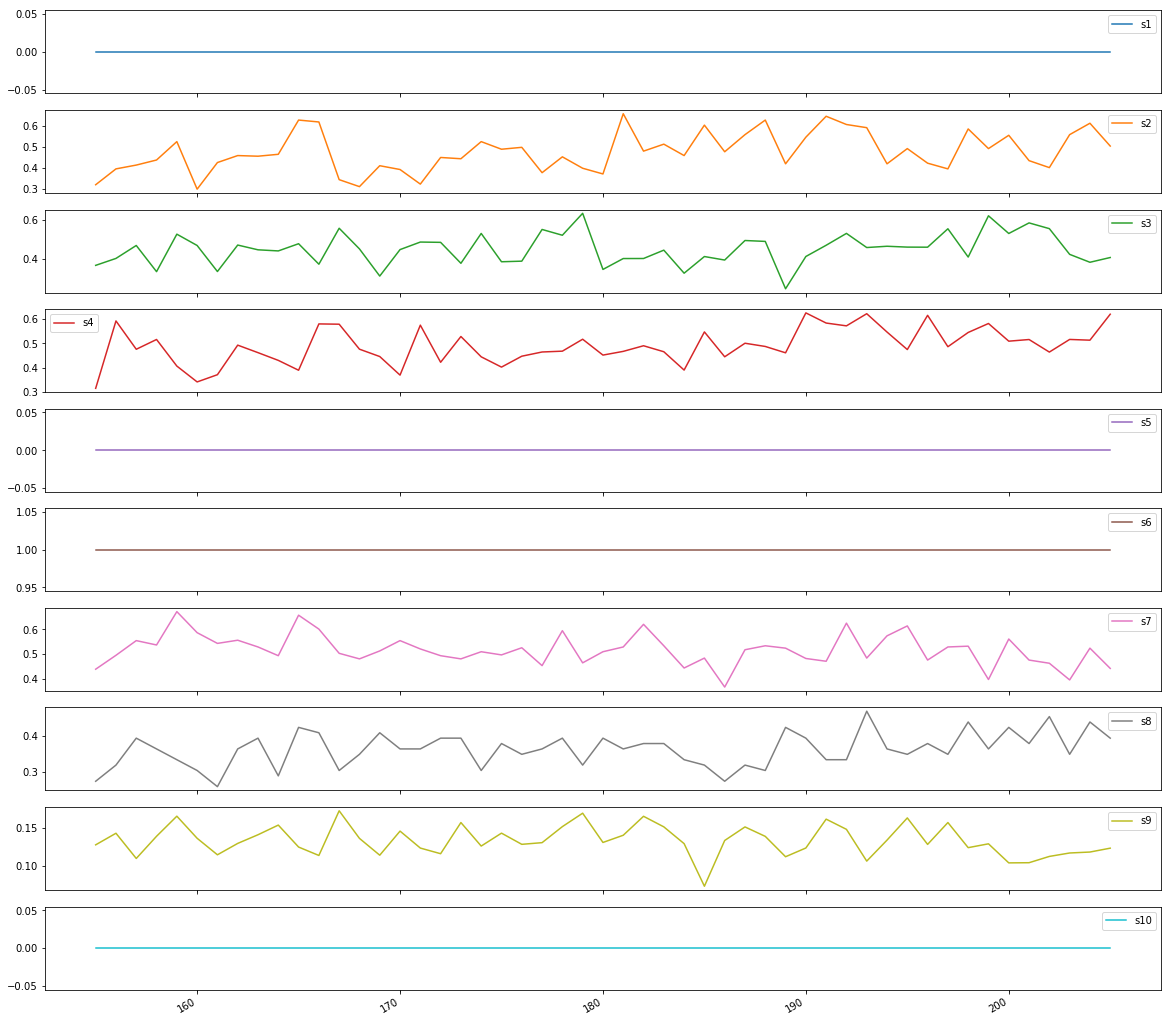

In [0]:
ax1 = last_cycles_1.plot(subplots=True, sharex=True, figsize=(20,20))

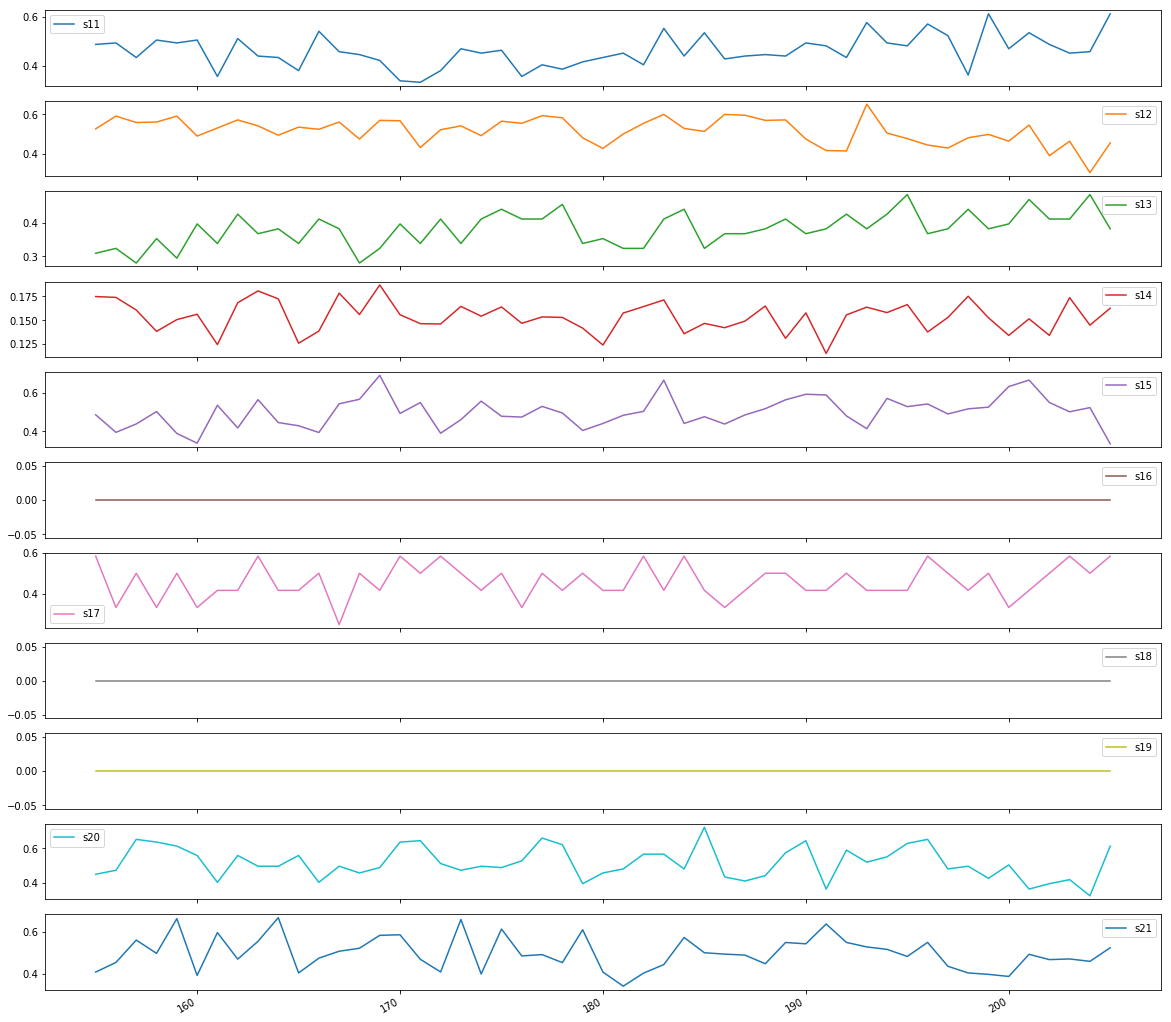

In [0]:
ax2 = last_cycles_2.plot(subplots=True, sharex=True, figsize=(20,20))

### Construct the LSTM input

Keras LSTM layers expect a matrix (3-dimensional array) with the following format.
Each row represents one window. Considering one window, the second dimension describes one of the L cycles of that window. Considering one window and one of its cycles, the 3rd dimension describes the value along the different columns. 

Note that all the windows are piled one after the other, independent of the engine they refer to.
Indeed, the goal of the LSTM is to process each window, independent of the engine identity (recall that all engines are of the same type). Based on the observation of the window, the LSTM tries to guess whether there will be a failure in the next w1 cycles.

We only consider for training all engines have at least L cycles of data available in the training set. We will ignore the others. If you need more data to train the LSTM, you could also to pad the missying cycles.

In [0]:
train_to_count = train_df_norm[['id','cycle']]
counts = pd.DataFrame(train_to_count.groupby('id').count() ).reset_index()
valid_ids = pd.DataFrame(counts[counts['cycle']>=L]['id'] )
train_df_clean = \
    pd.merge(train_df_norm, valid_ids, on='id', how='right')
print("Number of rows before and after cleaning ", \
      train_df_norm.shape[0],  train_df_clean.shape[0]) 


The following function takes a daframe df with the cycle information of just one engine.
It creates a list of matrices, each containing a window of size w of cycles. This function has the same output of list(gen_sequence(..) ), where gen_sequence(..) is the function defined in the reference tutorial. It is simpler, since it does not use yield operator.

In [0]:
# w: window length
# df: dataframe containing the data of a single engine
def gen_sequence_simple(df, w, feature_names):
    window_list = list()
    num_windows = 0
    
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = df[feature_names].values
    num_elements = data_array.shape[0]
    
    # In the following loop, the iterations will be
    #    (start,stop) = (0, w)
    #    (start,stop) = (1, w+1)
    #    (start,stop) = (2, w+2)
    # until stop<num_elements
    # In other words, we are creating a list of matrices
    # where each matrix contains the information of
    # a single window.
    for start, stop in zip(range(0, num_elements-w), \
                           range(w, num_elements)):
        new_window = data_array[start:stop, :]
        num_windows = num_windows + 1
        window_list.append(new_window)
        
    return window_list, num_windows

We first list the names of the features

In [0]:
sensor_cols = ['s' + str(i) for i in range(1,22)]
feature_cols = ['setting1', 'setting2', 'setting3', 'cycle']
feature_cols.extend(sensor_cols)
len(feature_cols)

We then create an array

In [0]:
all_windows = list()
num_of_all_wins = 0
for id in train_df_clean['id'].unique():
    windows_of_one_engine, num = gen_sequence_simple(\
        train_df_clean[train_df_clean['id']==id], L,\
                            feature_cols) 
    #
    all_windows.append(windows_of_one_engine)
    num_of_all_wins = num_of_all_wins + num
    

# Transform from list to array
all_windows = np.concatenate(all_windows).astype(np.float32)
print('Dimensions=', all_windows.shape, '; num_of_all_wins=', num_of_all_wins)

We have obtained our 3-dimensional matrix, as we needed.

We now need to create the label array, i.e., an array that associates to each window a binary value indicating whether the engine is going to fail within the next w1 cycles from the end of that window.

In other words, we associate to each window the label1 value of its last cycle.

In [0]:
# function to generate labels
#    id_df: dataframe of a single engine
#    win_len: window length
#    label: name of the label containing the value we 
#           want to predict
def gen_labels(id_df, win_len, label):
    cycle_labels_array = id_df[label].values
    num_cycles = cycle_labels_array.shape[0]
    
    # Note that the label we need to associate to the
    # 1st window is the label value of its last cycle,
    # i.e., the label value of the win_len-th cycle. This
    # value is the win_len-th in the cycle_labels_array.
    #
    # Similarly, the label we need to associate to the
    # 2nd window is the one of its last cycle, which is at
    # the (win-len + 1)-th position in the cycle_labels_array
    # And so on and so forth. 
    return cycle_labels_array[win_len:num_cycles, :]

In [0]:
# generate labels
label_gen = [gen_labels(train_df_clean[train_df_clean['id']==id], L, ['label1']) 
             for id in train_df_clean['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

We are now ready to set up the LSTM net.

## Training

In [0]:
# build the network
nb_features = all_windows.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(L, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
print(model.summary())

In [0]:
%%time
# fit the network
model.fit(all_windows, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

In [0]:
# training metrics
scores = model.evaluate(all_windows, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

In [0]:
# make predictions and compute confusion matrix
y_pred = model.predict_classes(all_windows,verbose=1, batch_size=200)
y_true = label_array.astype(np.int32)

In [0]:
y_true = [np.asscalar(n) for n in y_true]
y_pred = [np.asscalar(n) for n in y_pred]

In [0]:
# From https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
classes = np.array(['ok', 'ko'])
np.set_printoptions(precision=2)
plot_confusion_matrix(y_true, y_pred, classes=classes, \
                      normalize=True,
                      title='Confusion matrix')
plt.show()

In [0]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

## Performance (metrics on test data)

We only compute the performance on the last window of each engine in the test set.

To input the test data into the LSTM, we have to transform them in a matrix with the same format as the training phase input.
This matrix is 3-dimensional. Each row corresponds to one window. We have just said that we will consider only the last window of each engine in the test set. Therefore, each row corresponds also to one single engine. 
Considering a single row (window), we will have one array for each of the L cycles composing the window. Each element of this array is one one of the features.

Let us just consider the engines with enough cycles recorded (at least L)

In [0]:
considered_engines = \
    [id for id in df['id'].unique() if len(df[ df['id']==id ])>=L ]
print ('Engines with enough cycles recorded: ', len(considered_engines))

In [0]:
df = test_df_merged


last_windows = list()
for id in considered_engines:
    # Only select the engines with enough cycles measured
    cycles = df[ df['id']==id ] # cycles of one engine
    cycles = cycles[feature_cols]
    last_window = cycles.values[-L:, ]
    last_windows.append(last_window)
    
last_windows = np.asarray(last_windows)
last_windows.shape

For each of the considered test engines, we take the binary label, which is the value of label1 of its last cycle

In [0]:
df = test_df_merged
label_array_test_last = list()

for id in considered_engines:
    cycles = df[df['id']== id ]
    bin_val = cycles.tail(1)['label1']
    label_array_test_last.extend(bin_val)

label_array_test_last = np.array(label_array_test_last)
label_array_test_last.shape
print('Number of failing engines: ', 
      sum(label_array_test_last == 1) )

In [0]:
# make predictions and compute confusion matrix
y_pred_test = model.predict_classes(last_windows)
y_true_test = label_array_test_last

In [0]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_true_test, y_pred_test, classes=classes, \
                      normalize=False,
                      title='Confusion matrix')
plt.show()

In [0]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

## Rubbish

To know when the engine will fail, instead of looking at the training data, we can look at the ground_truth data, which tells how many additional cycles each engine will work after the last recording

In [0]:
truth_df.head()

### Understanding gen{

In [0]:
toy = train_df_clean[train_df_clean['cycle']<=5]
toy = toy[ toy['id']<=2 ]
toy_cols = ['id','setting1', 'setting2', 'setting3']
toy = toy[toy_cols]
toy


In [0]:
# generator for the sequences
seq_gen = (list(gen_sequence(toy[toy['id']==id], \
                    L, toy_cols)) 
           for id in toy['id'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

In [0]:
all_windows = list()
for id in toy['id'].unique():
    windows_of_one_engine = \
        gen_sequence_simple(toy[toy['id']==id], L, toy_cols) 
    all_windows.append(windows_of_one_engine)
    
# Transform from list to array
all_windows = np.concatenate(all_windows).astype(np.float32)
all_windows.shape

### } Understanding gen

### Prova test{

Their code

In [0]:
df = test_df_merged
seq_array_test_last = [df[df['id']==id][feature_cols].values[-L:] 
                       for id in df['id'].unique() if len(df[df['id']==id]) >= L]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print('Number of unique ids=',len(df['id'].unique() ) )
seq_array_test_last.shape

In [0]:
seq_array_test_last

My code

In [0]:
last_windows = list()
last_window = []
considered_engines = 0
for id in df['id'].unique():
    # Only select the engines with enough cycles measured
    if len(df['id']==id) >= L :
        considered_engines = considered_engines + 1
        cycles = df[df['id']==id]
        cycles = cycles[feature_cols]
        last_window = cycles.values[-L:, ]
        last_windows.append(last_window)
        
print('Considered engines=', considered_engines)

last_windows = np.asarray(last_windows)
last_windows

### }Prova test

### Count the failing engines{

In [0]:
df = test_df_merged
seq_array_test_last = [df[df['id']==id][feature_cols].values[-L:] 
                       for id in df['id'].unique() if len(df[df['id']==id]) >= L]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print('Number of unique ids=',len(df['id'].unique() ) )
seq_array_test_last.shape

In [0]:
y_mask = [len(df[df['id']==id]) >= L for id in df['id'].unique()]

In [0]:
label_array_test_last = df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.int32)
print('shape:',label_array_test_last.shape )
label_array_test_last = [np.asscalar(n) for n in label_array_test_last]

In [0]:
count = 0
for n in  label_array_test_last:
    if n == 1:
        count = count + 1
        
count

### }Count the failing engines

## Time series analysis
Inspired by [this post](https://www.machinelearningplus.com/time-series/time-series-analysis-python/).

Let us consider again engine 3 and in particular the measurements of sensor s2

In [0]:
df_ts = engine_id3[['s2']]
df_ts.head()

,s2
80,0.246988
81,0.307229
82,0.533133
83,0.364458
84,0.382530


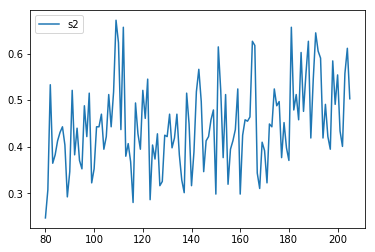

In [0]:
df_ts.plot()

### Stationarity
From visual inspection, it seems that the series is not stationary (before 110 it tends to be low, in [110,120] the variance is high, then, toward the end it tends to to stay higher than 0.4).

In [0]:
from statsmodels.tsa.stattools import adfuller, kpss
result = adfuller(df_ts['s2'].values, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

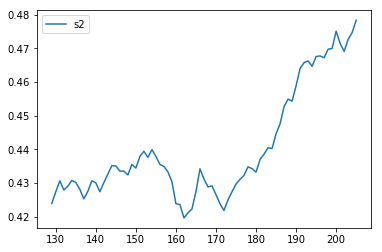

In [0]:
w=50
df_avg = df_ts.rolling(window=w).mean()
df_avg.plot()

### Decomposition

The simple seasonal_decompose from statsmodel only works with well defined timestamps, which requires periods like week, year, day, etc., to be recognizable in your data.

Since our data are a-temporal, we cannot use seasonal_decompose. We thus resort to a library written by Welch, which can be applied to any time-series, even if no timestamp is provided. The theory behind it is available [here](https://github.com/welch/seasonal#theory).

The trend is a continuous function $\hat g(t)$, in particular it is a polynomial of order 3. It is the result of polynomial regression, where the samples are the points $t_i, y_i$ of the original dataset. Actually, it is a weighted spline.

In [0]:
# From https://github.com/welch/seasonal
# You need to "pip install seasonal" on your anaconda environment 
# the first time you use it.
from seasonal import fit_seasons, adjust_seasons, fit_trend

s = df_ts['s2'].values

# Interesting values for trend: "line" and "spline"
seasons, trend = fit_seasons(s, trend="spline") 

if seasons != None:
    adjusted = adjust_seasons(s, seasons=seasons)
else:
    print("No periodicity has been detected")
    adjusted = s
    
residual = adjusted - trend
print(fit_trend.__doc__)

No periodicity has been detected
Fit a trend for a possibly noisy, periodic timeseries.

    Trend may be modeled by a line, cubic spline, or mean or median
    filtered series.

    Parameters
    ----------
    data : ndarray
        list of observed values
    kind : string ("mean", "median", "line", "spline", None)
        if mean, apply a period-based mean filter
        if median, apply a period-based median filter
        if line, fit a slope to median-filtered data.
        if spline, fit a piecewise cubic spline to the data
        if None, return zeros
    period : number
        seasonal periodicity, for filtering the trend.
        if None, will be estimated.
    ptimes : number
        multiple of period to use as smoothing window size

    Returns
    -------
    trend : ndarray

    


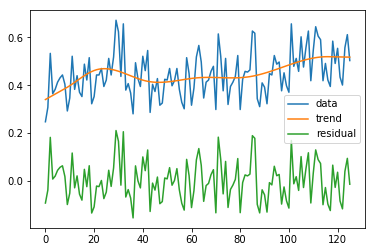

In [0]:
# visualize results
plt.figure()
plt.plot(s, label='data')
plt.plot(trend, label='trend')
plt.plot(residual, label='residual')
plt.legend(loc='best')

In [0]:
df_ts.index = pd.DatetimeIndex(freq="s", start=0, 
                                periods=df_ts.shape[0])
df_ts.head()

In [0]:
result_mul = seasonal_decompose(df_ts['s2'].values, 
                                model='multiplicative', 
                                extrapolate_trend='freq')

In [0]:
result_mul.plot()